# Refactor with gollum

We just did a significant overhaul with moving to gollum for preprocessing, settling with pseudo-Voigt, and 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [2]:
from gollum.phoenix import PHOENIXSpectrum

In [3]:
import astropy.units as u

In [4]:
spec = PHOENIXSpectrum(teff=4700, logg=4.5).divide_by_blackbody().normalize()

In [5]:
x_vector = spec.wavelength.value

In [6]:
y_vector = spec.flux.value

<AxesSubplot:xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

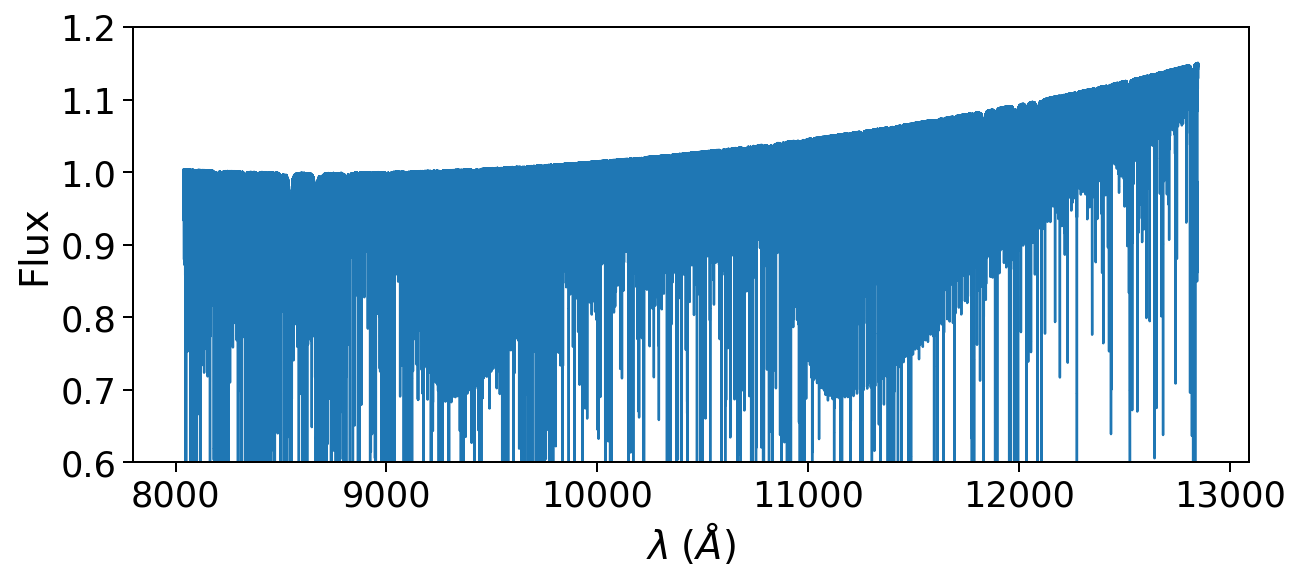

In [7]:
spec.plot()

# Emulator

In [8]:
import torch

In [9]:
from blase.emulator import PhoenixEmulator

In [10]:
! ls -t1 ../examples/*.pt

../examples/native_res_0p1prom.pt


In [11]:
! du -hs '../examples/native_res_0p1prom.pt'

128K	../examples/native_res_0p1prom.pt


In [12]:
with torch.no_grad():
    model_params = torch.load('../examples/native_res_0p1prom.pt')

In [13]:
len(model_params['amplitudes'])

3954

In [14]:
bad_mask = (model_params['amplitudes']>0)

In [15]:
bad_mask.sum()

tensor(4, device='cuda:0')

In [16]:
model_params['amplitudes'][bad_mask] = 0

In [17]:
emulator = PhoenixEmulator(x_vector, y_vector, prominence=0.05,)

In [18]:
emulator.load_state_dict(model_params)

<All keys matched successfully>

This step takes a *TON* of RAM unless you use `torch.no_grad`!

Even then, we can run out of RAM.  We may have to resort to stacking.

In [19]:
emulator.wl_native

tensor([ 8038.0100,  8038.0200,  8038.0300,  ..., 12848.9400, 12848.9600,
        12848.9800], dtype=torch.float64)

In [20]:
sub_divisions = 20

In [21]:
n_wl = len(emulator.wl_native)

In [22]:
wl_blocks = []
for i in range(0, sub_divisions):
    start = i*n_wl//sub_divisions
    if i == (sub_divisions-1):
        end = None
    else:
        end = (i+1)*n_wl//sub_divisions
    this_wl = emulator.wl_native[start:end]
    wl_blocks.append(this_wl)

0 48378
48378 96756
96756 145135
145135 193513
193513 241892
241892 290270
290270 None


In [24]:
cloned_spectra = []
with torch.no_grad():
    for wl_block in wl_blocks:
        this_spectrum = emulator.forward(wl_block)
        cloned_spectra.append(this_spectrum)

In [33]:
cloned_spectrum = torch.cat(cloned_spectra)

In [34]:
type(cloned_spectrum), cloned_spectrum.shape

(torch.Tensor, torch.Size([338649]))

## $\pm 1.96\%$ residuals with a long tail

At native resolution

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

(8450.0, 8600.0)

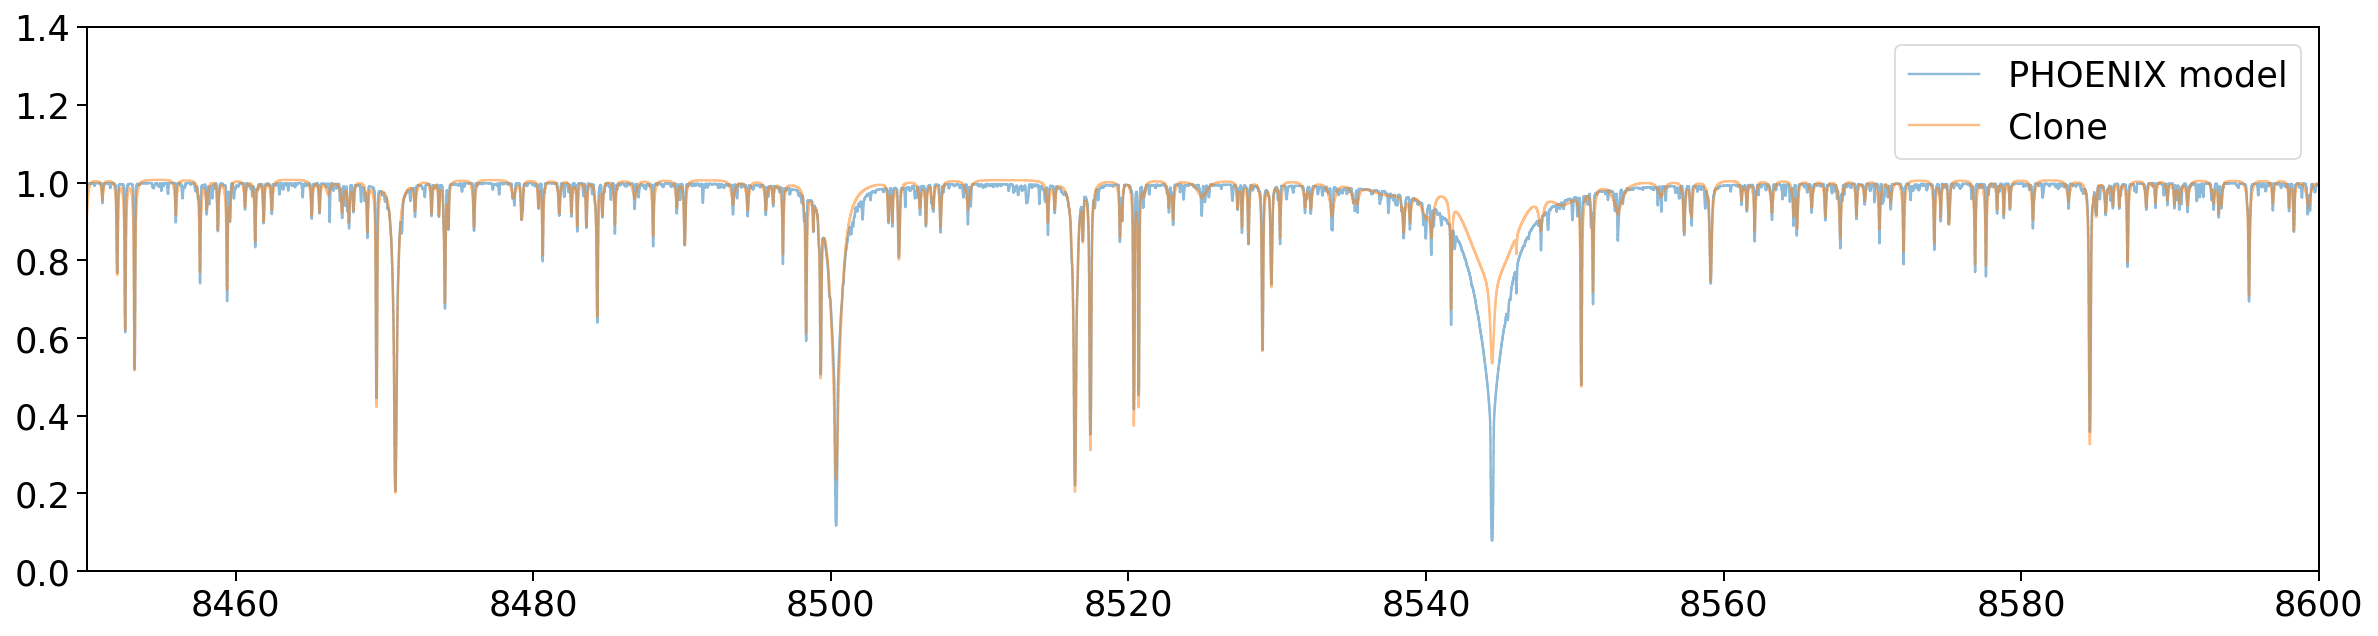

In [36]:
plt.figure(figsize=(20, 5))
plt.step(emulator.wl_native, emulator.flux_native, label='PHOENIX model', alpha=0.5)
plt.step(emulator.wl_native, cloned_spectrum.detach(), label='Clone', alpha=0.5)
plt.legend()
plt.ylim(0, 1.4)
plt.xlim(8_450, 8_600)
#plt.xlim(10_000, 10_010)
#plt.xlim(10_900, 11_010)

In [37]:
residual = emulator.flux_native - cloned_spectrum.detach()

In [38]:
stddev = torch.std(residual)

Text(0, 0.5, 'Residual (%)')

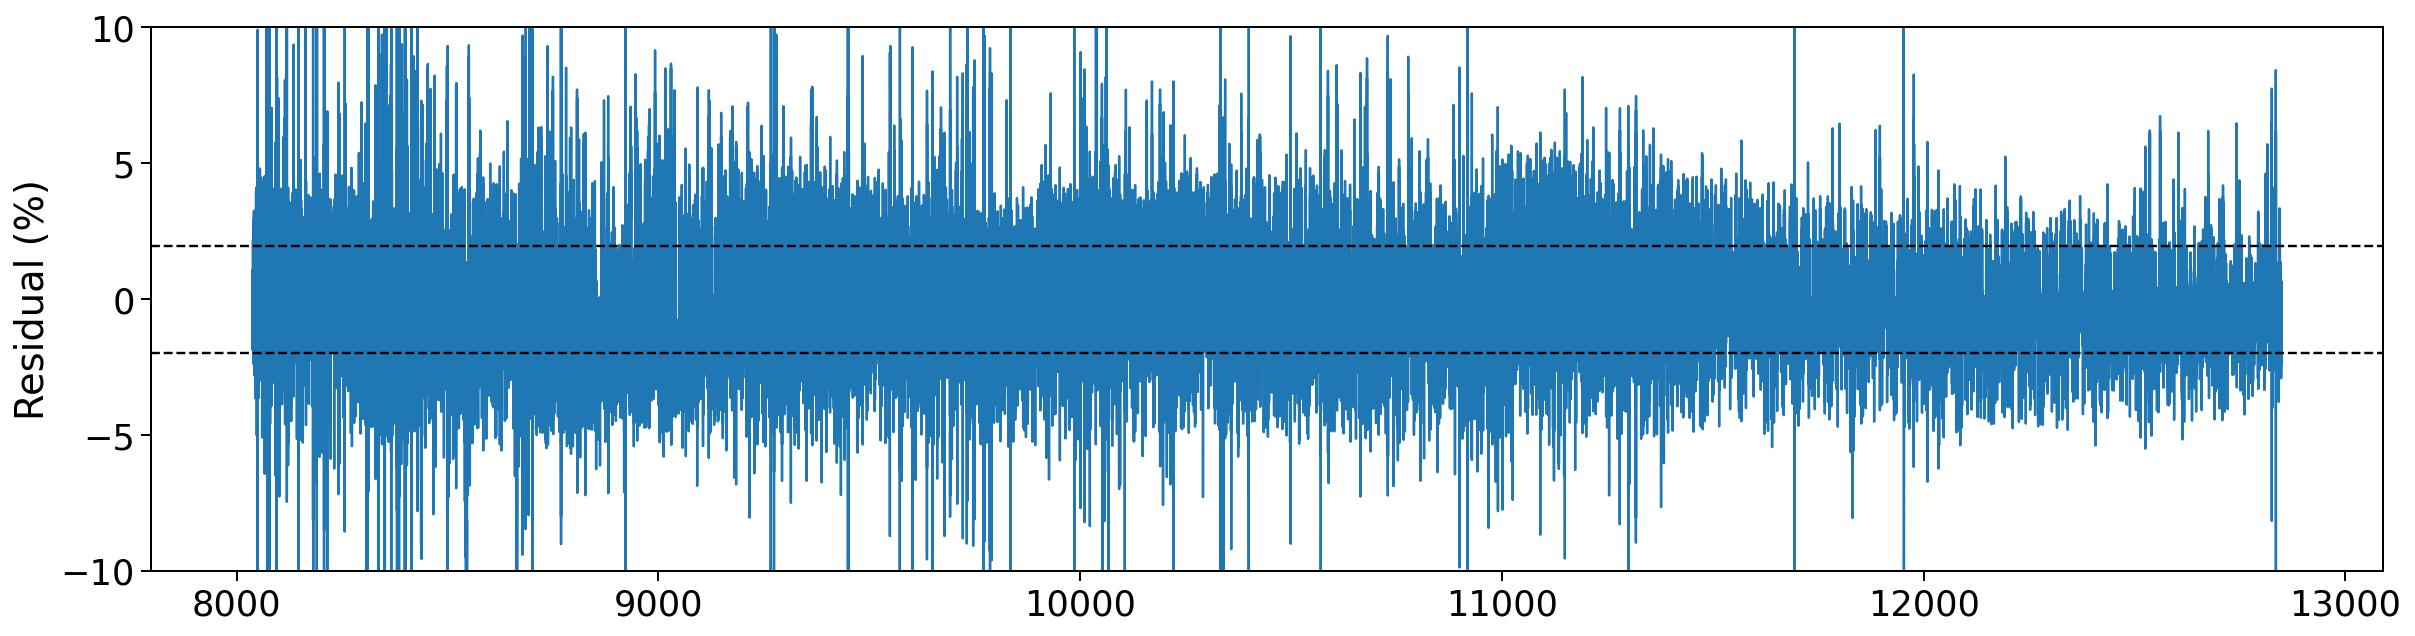

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, residual*100.0, label='Residual')
plt.axhline(+stddev*100, color='k', linestyle='dashed')
plt.axhline(-stddev*100, color='k', linestyle='dashed')
plt.ylim(-10, 10)
plt.ylabel('Residual (%)')

In [40]:
stddev

tensor(0.0196, dtype=torch.float64)

Hmmm, those residuals seem large compared to the reported residuals after training... did something go wrong when we loaded them in?  Is there some hysteresis when loading a model?  A rounding error?

How big are the residuals when you smooth them to HPF resolution?

## Smooth to HPF resolution

In [41]:
from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u

from muler.hpf import HPFSpectrumList

In [42]:
original_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=emulator.flux_native*u.dimensionless_unscaled)

In [43]:
clone_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=cloned_spectrum*u.dimensionless_unscaled)

In [44]:
echelle_orders = HPFSpectrumList.read('../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits')

In [45]:
hpf_spectrum = echelle_orders.sky_subtract(method='vector')\
                                .deblaze()\
                                .normalize()\
                                .remove_nans()\
                                .trim_edges((6,2042))\
                                .stitch()

In [46]:
def simulate_observation(spectrum):
    """Simulate an observation with HPF"""
    return spectrum.rotationally_broaden(13.5)\
                    .rv_shift(0.0)\
                    .instrumental_broaden(resolving_power=55_000)\
                    .resample(hpf_spectrum)

In [47]:
original_sim = simulate_observation(original_native)
clone_sim = simulate_observation(clone_native)

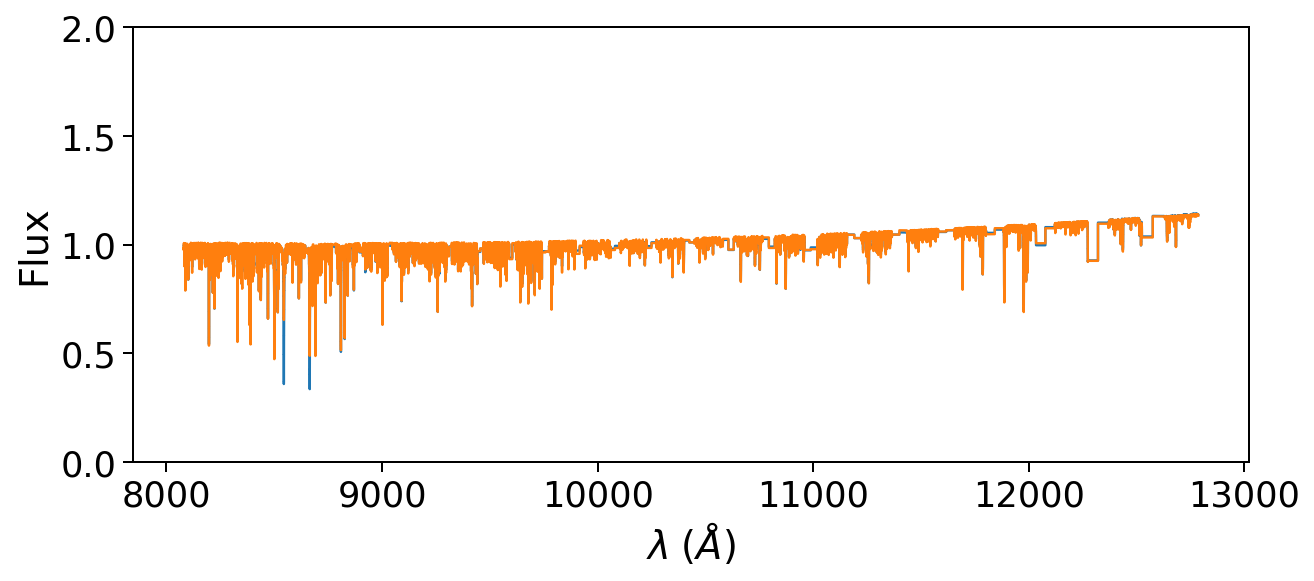

In [67]:
ax = original_sim.plot(ylo=0, yhi=2)
clone_sim.plot(ax=ax);

(10820.0, 10960.0)

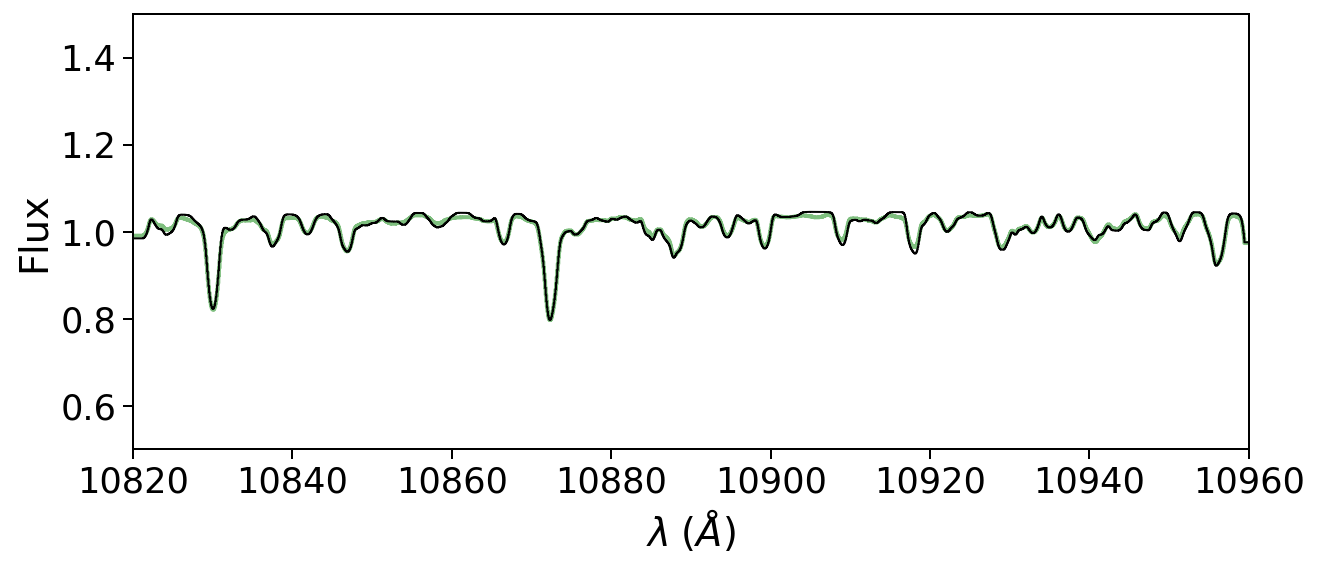

In [53]:
ax = original_sim.plot(ylo=0.5, yhi=1.5, color='g', lw=2, alpha=0.5)
clone_sim.plot(ax=ax, color='k', lw=1)
ax.plot()
ax.set_xlim(10820, 10960)

Yuck!  The cloning is not adequate at this zoom level.  Did we not train long enough?

In [54]:
residual_spec = (original_sim - clone_sim)*100

In [55]:
stddev = residual_spec.flux.std().value

In [56]:
stddev

0.9659106669266804

## $\pm 0.9\%$ residuals after smoothing and resampling


Text(0, 0.5, 'Residual (%)')

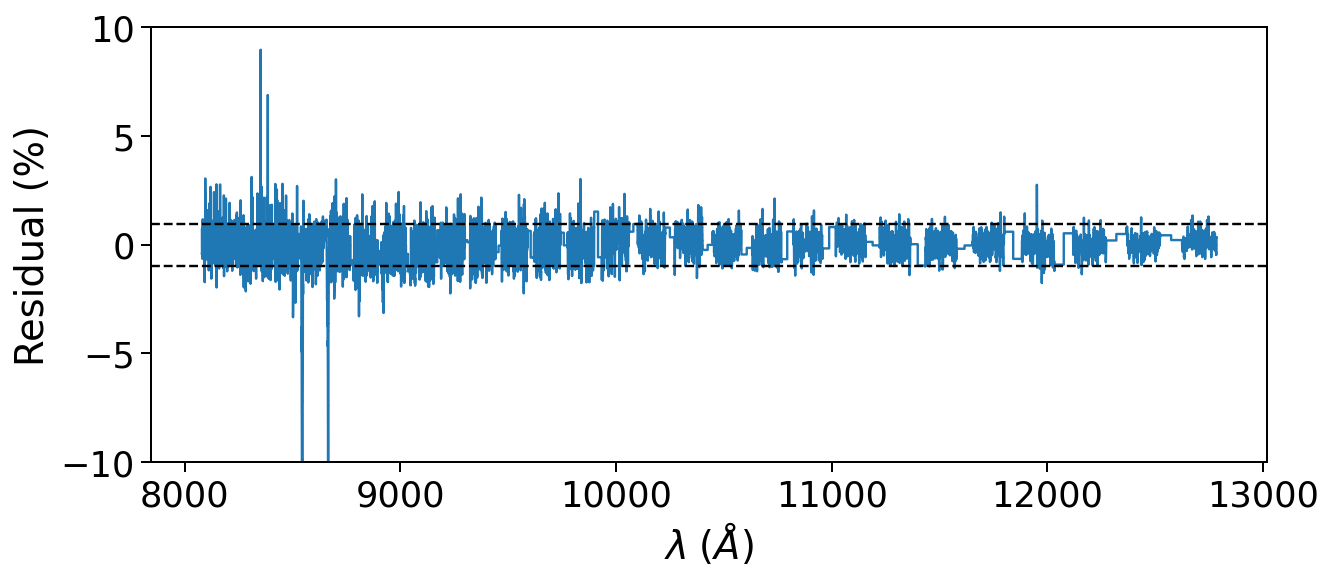

In [57]:
ax = residual_spec.plot(ylo=-10, yhi=10)
ax.axhline(+stddev, color='k', linestyle='dashed')
ax.axhline(-stddev, color='k', linestyle='dashed')
ax.set_ylabel('Residual (%)')

## How to get better performance?

1. More flexible continuum  
It should be like 5-20th order polynomial, or a GP

2. Longer training  
More like 1500 epochs, not 300

3. Better handling of deep lines with broad linewings  
Some more-flexible line shapes for those.

4. Better initialization  
Make a heuristic for where the lines start with amplitude/width and where they end up.